## Bayesian parameter estimation using Importance Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

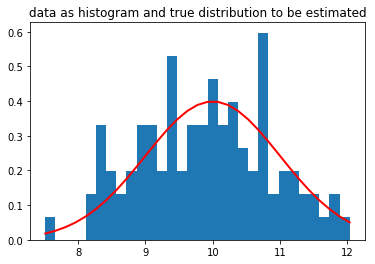

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal',
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

In [4]:
# Learn the unknown parameters using IS
bayes_estimator = BayesParameterEstimation(model=candidate_model, data=data, sampling_method = 'IS', nsamples=10000)

UQpy: Parameter estimation analysis completed!


0.9999999999999997


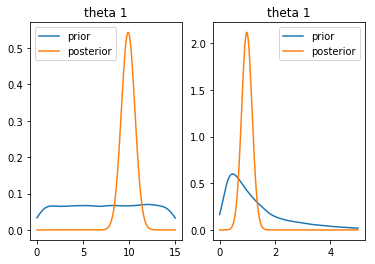

In [5]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='posterior')
ax[0].legend()
ax[0].set_title('theta 1')

domain = np.linspace(0, 5, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=w)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='posterior')
ax[1].legend()
ax[1].set_title('theta 1')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic equation, add some noise to it
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_quadratic.py', model_object_name = 'RunPythonModel', 
             var_names = ['theta_1', 'theta_2'])

data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[-2.08946402e-02  7.82884338e-01  5.66830952e-01  4.55367823e-01
  1.48990167e+00  4.36731082e+00  4.66396686e+00  5.32350953e+00
  8.19275243e+00  8.54173837e+00  1.00743450e+01  1.08341642e+01
  1.59293365e+01  1.52064561e+01  1.78840410e+01  2.19986058e+01
  2.46724224e+01  2.67190624e+01  3.06426099e+01  3.45191055e+01
  3.74216824e+01  4.12341888e+01  4.50512581e+01  4.94543087e+01
  5.39984861e+01  5.92886069e+01  6.19259447e+01  6.71754618e+01
  7.12937585e+01  7.57101047e+01  8.11001672e+01  8.54782778e+01
  9.32228460e+01  9.72281269e+01  1.02982350e+02  1.07845532e+02
  1.17377878e+02  1.22361917e+02  1.27840092e+02  1.33193113e+02
  1.40865601e+02  1.48842150e+02  1.56100044e+02  1.60589357e+02
  1.70867672e+02  1.79359210e+02  1.84917391e+02  1.94132388e+02
  2.02054768e+02  2.08949149e+02]


In [7]:
candidate_model = Model(n_params=2, model_type='python', model_script='pfn_quadratic.py', 
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method='IS', nsamples=200000,
                                           pdf_proposal=['normal','normal'], pdf_proposal_params=[[0, 2], [0, 2]])

UQpy: Parameter estimation analysis completed!


0.9999999999999999


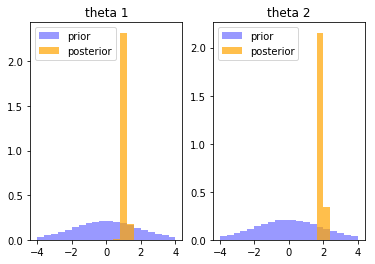

In [9]:
s = bayes_estimator.samples
w = bayes_estimator.weights
print(sum(w))

# print results
fig, ax = plt.subplots(1,2)
for i in range(2):
    ax[i].hist(x=s[:,i], weights=None, density=True, range=(-4, 4), bins = 20, color='blue', alpha=0.4, label='prior')
    ax[i].hist(x=s[:,i], weights=w, density=True, range=(-4, 4), bins = 20, color='orange', alpha=0.7, label='posterior')
    ax[i].legend()
    ax[i].set_title('theta {}'.format(i+1))

plt.show()

Effective sample size is ne=17.599009663611927, for a total number of samples=200000
max_weight = 0.10460487740282337, min_weight = 0.0


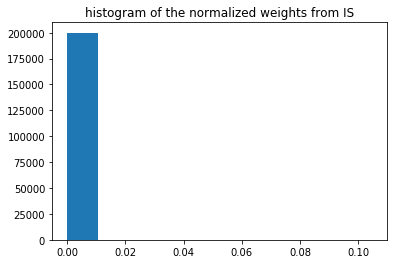

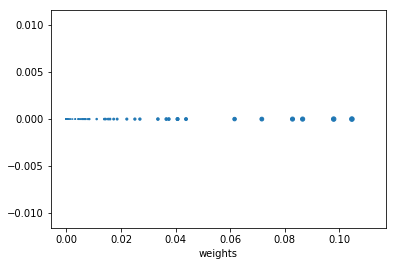

In [10]:
Diagnostics(sampling_method='IS', sampling_outputs = bayes_estimator)